In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

## Data Processing

In [3]:
df = pd.read_csv('stock_data.csv')
df.head()

,date,ticker,open,high,low,close,volume,outstanding_share,turnover,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_mv,qfq_factor
0,2005-01-04,sh600000,0.77,0.77,0.75,0.76,3808939.0,900000000.0,0.004232,17.1990,14.4219,2.0777,3.1439,2.2097,6.9549,6.9549,2693520.0,8.895254
1,2005-01-05,sh600000,0.76,0.76,0.74,0.75,5225244.0,900000000.0,0.005806,16.9240,14.1913,2.0445,3.0937,2.1744,7.0679,7.0679,2650455.0,8.895254
2,2005-01-06,sh600000,0.75,0.75,0.73,0.74,4298099.0,900000000.0,0.004776,16.6991,14.0026,2.0173,3.0525,2.1455,7.1632,7.1632,2615220.0,8.895254
3,2005-01-07,sh600000,0.74,0.75,0.73,0.74,4362864.0,900000000.0,0.004848,16.7491,14.0446,2.0233,3.0617,2.1519,7.1418,7.1418,2623050.0,8.895254
4,2005-01-10,sh600000,0.75,0.77,0.74,0.77,7115260.0,900000000.0,0.007906,17.3240,14.0575,2.0082,3.1668,2.2258,6.9048,6.9048,2713095.0,8.895254


In [7]:
ticker = pd.read_csv('ticker_info.csv')
ticker.head()

,Unnamed: 0,ticker,company_name
0,0,sh600000,浦发银行
1,1,sh600004,白云机场
2,2,sh600006,东风汽车
3,3,sh600007,中国国贸
4,4,sh600008,首创环保


In [36]:
stock = df.copy()
data_orig = pd.merge(stock,ticker,how='left',on='ticker')
data_orig.head()

,date,ticker,open,high,low,close,volume,outstanding_share,turnover,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_mv,qfq_factor,Unnamed: 0,company_name
0,2005-01-04,sh600000,0.77,0.77,0.75,0.76,3808939.0,900000000.0,0.004232,17.1990,14.4219,2.0777,3.1439,2.2097,6.9549,6.9549,2693520.0,8.895254,0,浦发银行
1,2005-01-05,sh600000,0.76,0.76,0.74,0.75,5225244.0,900000000.0,0.005806,16.9240,14.1913,2.0445,3.0937,2.1744,7.0679,7.0679,2650455.0,8.895254,0,浦发银行
2,2005-01-06,sh600000,0.75,0.75,0.73,0.74,4298099.0,900000000.0,0.004776,16.6991,14.0026,2.0173,3.0525,2.1455,7.1632,7.1632,2615220.0,8.895254,0,浦发银行
3,2005-01-07,sh600000,0.74,0.75,0.73,0.74,4362864.0,900000000.0,0.004848,16.7491,14.0446,2.0233,3.0617,2.1519,7.1418,7.1418,2623050.0,8.895254,0,浦发银行
4,2005-01-10,sh600000,0.75,0.77,0.74,0.77,7115260.0,900000000.0,0.007906,17.3240,14.0575,2.0082,3.1668,2.2258,6.9048,6.9048,2713095.0,8.895254,0,浦发银行


In [46]:
# To exclude ST stocks
data = data_orig.copy()
data.drop(data[data['company_name'].str.contains("ST")].index, inplace=True)

In [47]:
data['RET'] = data['close'].pct_change()
data['lag_RET'] = data.groupby('ticker')['RET'].shift()
data['date'] = pd.to_datetime(data['date'])
data.drop(['open','high','low','close','outstanding_share','Unnamed: 0','company_name'], axis=1, inplace=True)
data.dropna(inplace=True)
data.set_index(['ticker','date'], inplace=True)
data.sort_index(inplace=True)

In [49]:
data

volume  turnover       pe   pe_ttm      pb       ps  \
ticker   date                                                                 
sh600000 2005-01-06  4298099.0  0.004776  16.6991  14.0026  2.0173   3.0525   
         2005-01-07  4362864.0  0.004848  16.7491  14.0446  2.0233   3.0617   
         2005-01-10  7115260.0  0.007906  17.3240  14.0575  2.0082   3.1668   
         2005-01-11  6895175.0  0.007661  17.5240  14.2198  2.0314   3.2033   
         2005-01-12  2797449.0  0.003108  17.4240  14.1386  2.0198   3.1851   
...                        ...       ...      ...      ...     ...      ...   
sz301047 2022-05-05  1070769.0  0.033151  20.6537  29.6202  2.4038  15.4059   
         2022-05-06   856664.0  0.026522  20.3971  29.2522  2.3739  15.2145   
         2022-05-09   613866.0  0.019005  20.6142  29.5636  2.3992  15.3765   
         2022-05-10   912969.0  0.028265  21.2279  30.4437  2.4706  15.8342   
         2022-05-11   966498.0  0.029923  21.1292  30.3021  2.4591  15.7606   

                      ps_ttm  dv_ratio  dv_ttm   total_mv  qfq_factor  \
ticker   date                                                           
sh600000 2005-01-06   2.1455    7.1632  7.1632  2615220.0    8.895254   
         2005-01-07   2.1519    7.1418  7.1418  2623050.0    8.895254   
         2005-01-10   2.2258    6.9048  6.9048  2713095.0    8.895254   
         2005-01-11   2.2515    6.8260  6.8260  2744415.0    8.895254   
         2005-01-12   2.2386    6.8651  6.8651  2728755.0    8.895254   
...                      ...       ...     ...        ...         ...   
sz301047 2022-05-05  21.7242    0.0000  4.5727  1487092.0    1.000000   
         2022-05-06  21.4543    0.0000  4.6302  1468616.4    1.000000   
         2022-05-09  21.6827    0.0000  4.5814  1484249.6    1.000000   
         2022-05-10  22.3282    0.0000  4.4490  1528436.0    1.000000   
         2022-05-11  22.2243    0.0000  4.4698  1521330.0    1.000000   

                          RET   lag_RET  
ticker   date                            
sh600000 2005-01-06 -0.013333 -0.013158  
         2005-01-07  0.000000 -0.013333  
         2005-01-10  0.040541  0.000000  
         2005-01-11  0.000000  0.040541  
         2005-01-12  0.000000  0.000000  
...                       ...       ...  
sz301047 2022-05-05  0.027220  0.001340  
         2022-05-06 -0.012424  0.027220  
         2022-05-09  0.010645 -0.012424  
         2022-05-10  0.029770  0.010645  
         2022-05-11 -0.004649  0.029770  

[5629473 rows x 13 columns]

In [77]:
def perf(sortvar):
    
    # creating the quintiles
    data['Q'] = data.groupby('DATE')[sortvar].apply(quintiles)
    
    # computing quintile portfolio returns
    ports = data.groupby(['Q','DATE'])['RET'].mean()
    
    # printing out basic statistics on each portfolio
    print(ports.groupby('Q').describe())
    
    # computing high minus low portfolios
    hml = ports.loc[5] - ports.loc[1]
    
    return hml

def stats(hml):
    # printing basic statistics plus sharpe and t-stat
    stats = hml.describe()
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)    
    return stats
    
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

## Strategy 1: Baseline

In [202]:
#df['Category'] = pd.qcut(l, q = [0, 0.25, 0.5, 0.75, 1], labels = [1,2,3,4])
data['quintiles'] = data.groupby('date')['lag_RET'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 5, 
                                                                                labels = range(1,6)))
#data['quintiles'] = data.groupby('date')['lag_RET'].apply(quintiles)
data.groupby('quintiles')['RET'].describe()

data0ports = data.groupby(['quintiles','date'])['RET'].mean()
data0ports.dropna(inplace=True)

lmh_baseline = data0ports.loc[1] - data0ports.loc[5]
mean = lmh_baseline.describe().loc['mean']
std = lmh_baseline.describe().loc['std']
sharpe = mean/std * np.sqrt(12)

outcome = pd.DataFrame(np.array([[mean, std, sharpe]]), columns=[['Mean','Std','Sharpe Ratio']], 
                           index=['baseline'])
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.0022,0.010556,-0.722107


## Strategy 2: Low Volatility

In [188]:
data['STD'] = (data.groupby('ticker')['lag_RET'].rolling(250).std() * np.sqrt(12)) \
                    .reset_index(0, drop=True).sort_index()

In [189]:
data = data.dropna(subset=['RET','STD'])

In [190]:
data['low_volat'] = data.groupby('date').apply(lambda x: x['STD'] <= x['STD'].mean()).droplevel(0)
low_vol = data[data['low_volat']]

#low_vol['qcut'] = low_vol.groupby('date')['lag_RET'].apply(lambda x: pd.qcut(x, 5, range(1, 6)))
low_vol['qcut'] = low_vol.groupby('date')['lag_RET'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 5, 
                                                                                 labels = range(1,6)))
low_vol.groupby('qcut')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
qcut,,,,,,,,
1,494330.0,-0.000119,0.027758,-0.200055,-0.013096,0.000000,0.012865,0.713826
2,491989.0,0.000884,0.024333,-0.140904,-0.010191,0.000865,0.012121,0.231076
3,492041.0,0.000987,0.023876,-0.203125,-0.009967,0.000332,0.011843,0.275809
4,491989.0,0.000796,0.024733,-0.150306,-0.010929,0.000000,0.011852,0.576000
5,493572.0,0.001106,0.030248,-0.234714,-0.014346,-0.000698,0.013582,1.874036


In [204]:
lmh_lowvolat = low_vol.groupby(['qcut','date'])['RET'].mean().loc[1]  \
                    - low_vol.groupby(['qcut','date'])['RET'].mean().loc[5]

mean = lmh_lowvolat.mean()
std = lmh_lowvolat.std()
sharpe = mean / std * np.sqrt(12)

In [205]:
outcome.loc['low volatility'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309


## Strategy 3: Low Volume

In [206]:
data['low_volume'] = data.groupby('date').apply(lambda x: x['volume'] <= x['volume'].median()).droplevel(0)

data3_low = data[data['low_volume']]
data3_low['quintiles'] = data3_low.groupby('date')['lag_RET'].transform(lambda x: pd.qcut(x.rank(method='first'), 
                                                                                          q = 5, labels = range(1,6)))
data3ports_low = data3_low.groupby(['quintiles','date'])['RET'].mean()

lmh_lowvolume = data3ports_low.loc[1] - data3ports_low.loc[5]
mean = lmh_lowvolume.describe()[1]
std = lmh_lowvolume.describe()[2]
sharpe = mean/std* np.sqrt(12)

outcome.loc['low volume'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527


In [207]:
combine = .5 * lmh_lowvolume + .5 *lmh_lowvolat
comb_stats = stats(.5 * lmh_lowvolume + .5 *lmh_lowvolat)
mean = comb_stats.loc['mean']
std = comb_stats.loc['std']
sharpe = mean / std * np.sqrt(12)

outcome.loc['low volatility + low volume'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527
low volatility + low volume,-0.000754,0.008736,-0.298998


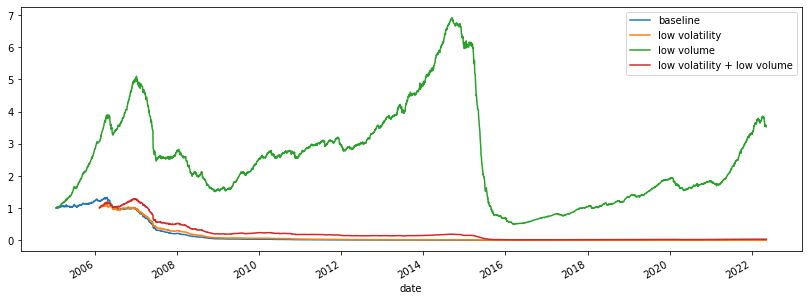

In [196]:
(1+lmh_baseline).cumprod().plot(figsize=(14,5), label='baseline')
(1+lmh_lowvolat).cumprod().plot(label='low volatility')
(1+lmh_lowvolume).cumprod().plot(label='low volume')
(1+combine).cumprod().plot(label='low volatility + low volume')

plt.legend()
plt.savefig('fundamental.jpg')

## Strategy 4: Models

### Predict 'RET' using XGBoost Model

In [97]:
import xgboost as xgb

data = data.reset_index()
date_list = sorted(data.date.drop_duplicates())

columns = ['turnover','pe','pe_ttm','pb','ps','ps_ttm','dv_ratio','dv_ttm','total_mv']

data['xgb_pred'] = np.nan

for i in range(1,len(date_list)):
    train = data.loc[data.date == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(data.loc[data.date == date_list[i], columns])
    
    regout = xgb.XGBRegressor(n_estimators=100).fit(X, y)

    data.loc[data.date == date_list[i], 'xgb_pred'] = regout.predict(X_pred)

In [98]:
xgbmodel = data.dropna(subset=['xgb_pred'])
xgbmodel['xgb_quintile'] = \
        xgbmodel.groupby('date')['xgb_pred'].apply(quintiles)
xgbmodel.groupby('xgb_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
xgb_quintile,,,,,,,,
1,1120768.0,-0.000626,0.029946,-0.200307,-0.014634,0.000000,0.013597,0.228477
2,1118196.0,-0.000482,0.026995,-0.266871,-0.013347,0.000000,0.012766,0.200561
3,1118233.0,-0.000213,0.027111,-0.200023,-0.013436,0.000000,0.012987,0.500000
4,1118198.0,0.000340,0.028705,-0.234714,-0.014141,0.000000,0.014060,0.467700
5,1119920.0,0.004316,0.035888,-0.349206,-0.014964,0.001499,0.020964,1.874036


In [208]:
hml_xgb = xgbmodel.groupby(['xgb_quintile','date'])['RET'].mean().loc[5]  \
                    - xgbmodel.groupby(['xgb_quintile','date'])['RET'].mean().loc[1]

mean = hml_xgb.mean()
std = hml_xgb.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow xgboost'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527
low volatility + low volume,-0.000754,0.008736,-0.298998
highminuslow xgboost,0.006172,0.010537,2.029166


### Predict 'RET' using Random Forest

In [101]:
date_list = sorted(data.date.drop_duplicates())

columns = ['turnover','pe','pe_ttm','pb','ps','ps_ttm','dv_ratio','dv_ttm','total_mv','qfq_factor']

rfmodel = data.dropna(subset=columns)
rfmodel['rf_pred'] = np.nan

for i in range(1,len(date_list)):
    train = rfmodel.loc[rfmodel.date == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(rfmodel.loc[rfmodel.date == date_list[i], columns])
    
    regout = RandomForestRegressor().fit(X, y)

    rfmodel.loc[rfmodel.date == date_list[i], 'rf_pred'] = regout.predict(X_pred)

In [102]:
rfmodel = rfmodel.dropna(subset=['rf_pred'])
rfmodel['rf_quintile'] = \
        rfmodel.groupby('date')['rf_pred'].apply(quintiles)
rfmodel.groupby('rf_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
rf_quintile,,,,,,,,
1,1120768.0,-0.000958,0.029042,-0.203125,-0.014303,0.000000,0.012922,0.563694
2,1118196.0,-0.000733,0.026851,-0.200307,-0.013492,0.000000,0.012500,0.200627
3,1118228.0,-0.000435,0.027178,-0.200000,-0.013699,0.000000,0.012903,0.282258
4,1118196.0,0.000345,0.028837,-0.234714,-0.014286,0.000000,0.014184,0.500000
5,1119927.0,0.005117,0.036460,-0.349206,-0.014674,0.002294,0.022330,1.874036


In [209]:
hml_rf = rfmodel.groupby(['rf_quintile','date'])['RET'].mean().loc[5]  \
                    - rfmodel.groupby(['rf_quintile','date'])['RET'].mean().loc[1]

mean = hml_rf.mean()
std = hml_rf.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow randomforest'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527
low volatility + low volume,-0.000754,0.008736,-0.298998
highminuslow xgboost,0.006172,0.010537,2.029166
highminuslow randomforest,0.007488,0.011772,2.203620


### Predict 'RET' using Linear Regression

In [125]:
columns = ['turnover','pe','pe_ttm','pb','ps','ps_ttm','dv_ratio','dv_ttm','total_mv','qfq_factor']

lrmodel = data.dropna(subset=columns)
lrmodel['lr_pred'] = np.nan

for i in range(1,len(date_list)):
    
    X, y = lrmodel.loc[lrmodel.date == date_list[i-1], columns], lrmodel.loc[lrmodel.date == date_list[i-1], 'RET']
    X_pred = pd.DataFrame(lrmodel.loc[lrmodel.date == date_list[i], columns])
    
    regout = sm.OLS(endog=y, exog=X).fit()

    lrmodel.loc[lrmodel.date == date_list[i], 'lr_pred'] = regout.predict(X_pred)

In [126]:
lrmodel = lrmodel.dropna(subset=['lr_pred'])
lrmodel['lr_quintile'] = lrmodel.groupby('date')['lr_pred'].apply(quintiles)
lrmodel.groupby('lr_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
lr_quintile,,,,,,,,
1,1120768.0,-0.000916,0.027193,-0.212121,-0.012920,0.000000,0.010909,1.874036
2,1118196.0,-0.001050,0.026269,-0.203125,-0.013423,0.000000,0.011577,1.287537
3,1118228.0,-0.000576,0.027176,-0.200307,-0.014128,0.000000,0.012987,0.231076
4,1118196.0,0.000617,0.029607,-0.200238,-0.014925,0.000258,0.015686,0.282258
5,1119927.0,0.005260,0.037644,-0.349206,-0.015455,0.003554,0.024096,0.802139


In [210]:
hml_lr = lrmodel.groupby(['lr_quintile','date'])['RET'].mean().loc[5]  \
                    - lrmodel.groupby(['lr_quintile','date'])['RET'].mean().loc[1]

mean = hml_lr.mean()
std = hml_lr.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow linear'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527
low volatility + low volume,-0.000754,0.008736,-0.298998
highminuslow xgboost,0.006172,0.010537,2.029166
highminuslow randomforest,0.007488,0.011772,2.203620
highminuslow linear,0.007265,0.010926,2.303384


### Predict 'RET' using Decision Tree

In [112]:
from sklearn.tree import DecisionTreeRegressor

date_list = sorted(data.date.drop_duplicates())

columns = ['turnover','pe','pe_ttm','pb','ps','ps_ttm','dv_ratio','dv_ttm','total_mv','qfq_factor']

dtmodel = data.dropna(subset=columns)
dtmodel['dt_pred'] = np.nan

for i in range(1,len(date_list)):
    train = dtmodel.loc[dtmodel.date == date_list[i-1]].dropna(subset=columns)
    X, y = train[columns], train['RET']
    
    X_pred = pd.DataFrame(dtmodel.loc[dtmodel.date == date_list[i], columns])
    
  
    regout = DecisionTreeRegressor().fit(X, y)

    dtmodel.loc[dtmodel.date == date_list[i], 'dt_pred'] = regout.predict(X_pred)

In [114]:
dtmodel = dtmodel.dropna(subset=['dt_pred'])
dtmodel['dt_quintile'] = \
        dtmodel.groupby('date')['dt_pred'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 5, 
                                                                       labels = range(1,6)))
dtmodel.groupby('dt_quintile')['RET'].describe()

,count,mean,std,min,25%,50%,75%,max
dt_quintile,,,,,,,,
1,1120768.0,0.000576,0.032639,-0.266871,-0.016107,0.000000,0.016713,1.287537
2,1118196.0,-0.000369,0.026833,-0.203125,-0.013100,0.000000,0.012516,0.485294
3,1118228.0,-0.000415,0.025972,-0.200023,-0.012571,0.000000,0.011777,0.802139
4,1118196.0,-0.000046,0.027449,-0.200893,-0.013415,0.000000,0.012750,0.713826
5,1119927.0,0.003586,0.035563,-0.349206,-0.015748,0.001646,0.020764,1.874036


In [211]:
hml_dt = dtmodel.groupby(['dt_quintile','date'])['RET'].mean().loc[5]  \
                    - dtmodel.groupby(['dt_quintile','date'])['RET'].mean().loc[1]

mean = hml_dt.mean()
std = hml_dt.std()
sharpe = mean / std * np.sqrt(12)

outcome.loc['highminuslow decisiontree'] =[mean,std,sharpe]
outcome

,Mean,Std,Sharpe Ratio
baseline,-0.002200,0.010556,-0.722107
low volatility,-0.001715,0.009897,-0.600309
low volume,0.000207,0.008485,0.084527
low volatility + low volume,-0.000754,0.008736,-0.298998
highminuslow xgboost,0.006172,0.010537,2.029166
highminuslow randomforest,0.007488,0.011772,2.203620
highminuslow linear,0.007265,0.010926,2.303384
highminuslow decisiontree,0.003975,0.007938,1.734635


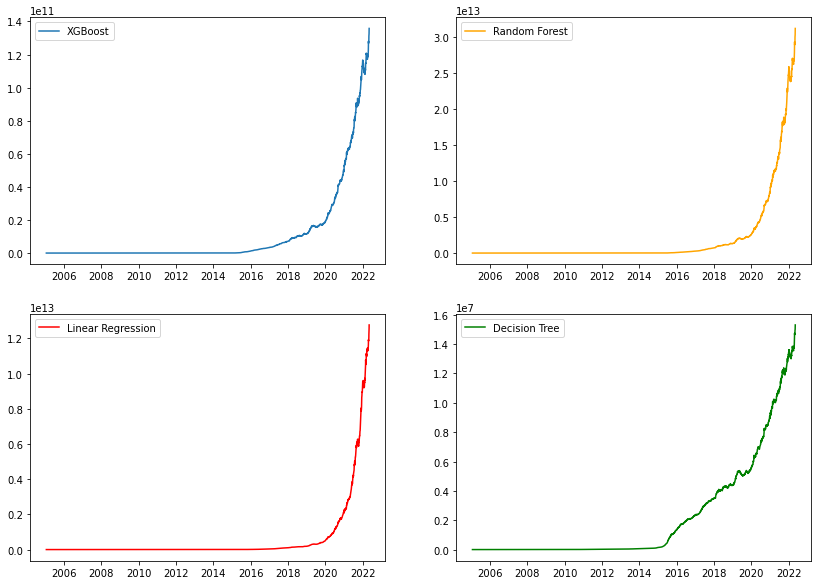

<Figure size 432x288 with 0 Axes>

In [199]:
plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)
plt.plot((1+hml_xgb).cumprod(),label='XGBoost')
plt.legend()

plt.subplot(2,2,2)
plt.plot((1+hml_rf).cumprod(),label='Random Forest',color='orange')
plt.legend()

plt.subplot(2,2,3)
plt.plot((1+hml_lr).cumprod(),label='Linear Regression',color='red')
plt.legend()

plt.subplot(2,2,4)
plt.plot((1+hml_dt).cumprod(),label='Decision Tree',color='green')
plt.legend()

plt.show()
plt.savefig('machinelearning.jpg')